# Stable Diffusion XL Pipeline Test

This notebook tests Stable Diffusion XL pipeline loading and device movement to debug the CPU float16 issue.


## Setup Checklist

1. `conda activate nodetool`
2. `pip install -U torch diffusers transformers accelerate huggingface_hub` if needed
3. `huggingface-cli login` (or set `HF_TOKEN`) if using gated models
4. Restart kernel after changing libraries


In [1]:
import platform
import torch
import diffusers
from diffusers import StableDiffusionXLPipeline
from diffusers import StableDiffusionXLPAGPipeline
from huggingface_hub import try_to_load_from_cache

device = "cuda"
print(f'Python: {platform.python_version()}')
print(f'Torch: {torch.__version__}')
print(f'Diffusers: {diffusers.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'Active device: {device}')


c:\Users\matti\anaconda3\envs\nodetool\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python: 3.11.10
Torch: 2.9.1+cu126
Diffusers: 0.36.0.dev0
CUDA available: True
Active device: cuda


## Test Configuration

Configure the test parameters below:


In [2]:
# Configuration
MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"
MODEL_PATH = "sd_xl_base_1.0.safetensors"
USE_FP16 = True  # Set to False to test float32
USE_PAG = True  # Use PAG pipeline (like in nodetool)

print(f"Model: {MODEL_ID}")
print(f"Path: {MODEL_PATH}")
print(f"Use FP16: {USE_FP16}")
print(f"Use PAG: {USE_PAG}")


Model: stabilityai/stable-diffusion-xl-base-1.0
Path: sd_xl_base_1.0.safetensors
Use FP16: True
Use PAG: True


## Load Pipeline


In [3]:
# Determine dtype
torch_dtype = torch.float16 if USE_FP16 else torch.float32
print(f"Loading with dtype: {torch_dtype}")

# Check cache
cache_path = try_to_load_from_cache(MODEL_ID, MODEL_PATH)
print(f"Cache path: {cache_path}")

# Load pipeline
if USE_PAG:
    pipeline_class = StableDiffusionXLPAGPipeline
else:
    pipeline_class = StableDiffusionXLPipeline

print(f"Loading {pipeline_class.__name__}...")

if cache_path:
    # Load from single file
    pipeline = pipeline_class.from_single_file(
        pretrained_model_link_or_path=cache_path,
        torch_dtype=torch_dtype,
        use_safetensors=True,
    )
else:
    # Load from repo
    pipeline = pipeline_class.from_pretrained(
        MODEL_ID,
        torch_dtype=torch_dtype,
    )

print(f"Pipeline loaded successfully")
print(f"Pipeline device: {next(pipeline.unet.parameters()).device}")
print(f"Pipeline dtype: {next(pipeline.unet.parameters()).dtype}")


Loading with dtype: torch.float16
Cache path: C:\Users\matti\.cache\huggingface\hub\models--stabilityai--stable-diffusion-xl-base-1.0\snapshots\462165984030d82259a11f4367a4eed129e94a7b\sd_xl_base_1.0.safetensors
Loading StableDiffusionXLPAGPipeline...


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.33it/s]

Pipeline loaded successfully
Pipeline device: cpu
Pipeline dtype: torch.float16


In [4]:
if torch.cuda.is_available():
    print("Moving pipeline to CUDA...")
    pipeline = pipeline.to("cuda")
    print(f"Pipeline moved to CUDA")
    print(f"Pipeline device: {next(pipeline.unet.parameters()).device}")
    print(f"Pipeline dtype: {next(pipeline.unet.parameters()).dtype}")
else:
    print("CUDA not available, skipping GPU move")


Moving pipeline to CUDA...
Pipeline moved to CUDA
Pipeline device: cuda:0
Pipeline dtype: torch.float16


## Test Inference


Generating image with prompt: 'a beautiful landscape'
Device: cuda:0
Dtype: torch.float16


100%|██████████| 10/10 [00:03<00:00,  3.18it/s]


Image generated successfully!


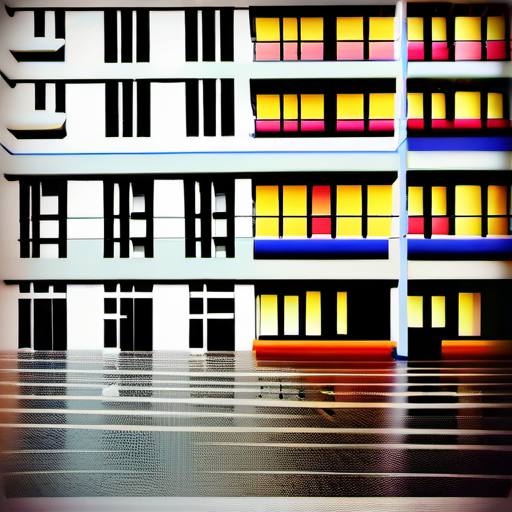

In [5]:
# Simple inference test
prompt = "a beautiful landscape"
negative_prompt = ""

print(f"Generating image with prompt: '{prompt}'")
print(f"Device: {next(pipeline.unet.parameters()).device}")
print(f"Dtype: {next(pipeline.unet.parameters()).dtype}")

image = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=10,  # Fewer steps for testing
    guidance_scale=7.0,
    width=512,
    height=512,
).images[0]

print("Image generated successfully!")
image


## Test Moving to CPU (This is where the crash happens)


In [6]:
# Check current dtype
current_dtype = next(pipeline.unet.parameters()).dtype
current_device = next(pipeline.unet.parameters()).device

print(f"Current device: {current_device}")
print(f"Current dtype: {current_dtype}")
print(f"Is float16: {current_dtype == torch.float16}")

if current_dtype == torch.float16:
    print("\n⚠️  WARNING: Pipeline uses float16")
    print("Moving float16 pipeline to CPU will crash!")
    print("\nAttempting move to CPU (this will fail)...")
    try:
        pipeline = pipeline.to("cpu")
        print("✅ Successfully moved to CPU")
    except Exception as e:
        print(f"❌ Error moving to CPU: {e}")
        print(f"Error type: {type(e).__name__}")
else:
    print("\n✅ Pipeline uses float32, safe to move to CPU")
    try:
        pipeline = pipeline.to("cpu")
        print("✅ Successfully moved to CPU")
        print(f"New device: {next(pipeline.unet.parameters()).device}")
    except Exception as e:
        print(f"❌ Error moving to CPU: {e}")


Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.


Current device: cuda:0
Current dtype: torch.float16
Is float16: True

⚠️  WARNING: Pipeline uses float16
Moving float16 pipeline to CPU will crash!

Attempting move to CPU (this will fail)...


Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, du

✅ Successfully moved to CPU


In [ ]:
# Move back to GPU first if needed
if torch.cuda.is_available():
    pipeline = pipeline.to("cuda")
    print("Moved back to CUDA")

# Safe move to CPU function
def safe_move_to_cpu(pipe):
    """Safely move pipeline to CPU, checking dtype first."""
    unet = getattr(pipe, "unet", None)
    if unet is None:
        print("No UNet found, cannot check dtype")
        return pipe
    
    current_dtype = next(unet.parameters()).dtype
    
    if current_dtype == torch.float16:
        print(f"⚠️  Pipeline uses {current_dtype}, skipping CPU move to avoid crash")
        return pipe
    
    print(f"✅ Pipeline uses {current_dtype}, safe to move to CPU")
    return pipe.to("cpu")

# Test safe move
print("Testing safe CPU move...")
pipeline = safe_move_to_cpu(pipeline)
print(f"Final device: {next(pipeline.unet.parameters()).device}")


## Compare: Float32 vs Float16


In [ ]:
# Test with float32
print("=" * 50)
print("TESTING WITH FLOAT32")
print("=" * 50)

if cache_path:
    pipeline_fp32 = pipeline_class.from_single_file(
        pretrained_model_link_or_path=cache_path,
        torch_dtype=torch.float32,
        use_safetensors=True,
    )
else:
    pipeline_fp32 = pipeline_class.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float32,
    )

if torch.cuda.is_available():
    pipeline_fp32 = pipeline_fp32.to("cuda")

print(f"FP32 Pipeline dtype: {next(pipeline_fp32.unet.parameters()).dtype}")
print("Attempting to move FP32 pipeline to CPU...")
try:
    pipeline_fp32 = pipeline_fp32.to("cpu")
    print("✅ FP32 pipeline successfully moved to CPU")
except Exception as e:
    print(f"❌ FP32 pipeline failed: {e}")

print("\n" + "=" * 50)
print("CONCLUSION:")
print("Float32 pipelines can be moved to CPU safely")
print("Float16 pipelines CANNOT be moved to CPU (crashes)")
print("Solution: Check dtype before moving to CPU")
